In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

from tqdm import tqdm

from matplotlib import pyplot as plt
import seaborn as sns

from modules.dataset import AudioDataset
from modules.transformer import TransformerModel
from modules.utils import process_audio_data, split_dataset

In [2]:
audio_dataset = AudioDataset('data/normal', 'data/whistle')

In [3]:
train_dataset, valid_dataset, test_dataset = split_dataset(audio_dataset)

In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [5]:
def train_model(model, train_loader, valid_loader, num_epochs, criterion, optimizer, device):
    model.to(device)
    
    train_loss_history, train_acc_history = [], []
    valid_loss_history, valid_acc_history = [], []

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        train_loss, train_corrects = 0.0, 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            
            predicted = torch.argmax(outputs, dim=1)
            train_corrects += torch.sum(predicted == labels).item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects / len(train_loader.dataset)
        
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        model.eval()  # Set the model to evaluation mode
        valid_loss, valid_corrects = 0.0, 0

        with torch.no_grad():
            for inputs, labels in tqdm(valid_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Validation]'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                valid_loss += loss.item() * inputs.size(0)
                
                predicted = torch.argmax(outputs, dim=1)
                valid_corrects += torch.sum(predicted == labels).item()

        valid_loss /= len(valid_loader.dataset)
        valid_acc = valid_corrects / len(valid_loader.dataset)
        
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}\n'
              f'Validation Loss: {valid_loss:.4f}, Validation Acc: {valid_acc:.4f}')

    return train_loss_history, train_acc_history, valid_loss_history, valid_acc_history

In [20]:
model = TransformerModel(n_features=1025, n_classes=2, n_heads=4, n_encoder_layers=4)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.000005)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loss_history, train_acc_history, valid_loss_history, valid_acc_history = train_model(model, train_loader, valid_loader, num_epochs=50, criterion=criterion, optimizer=optimizer, device=device)

In [8]:
torch.save(model.state_dict(), 'model.pth')

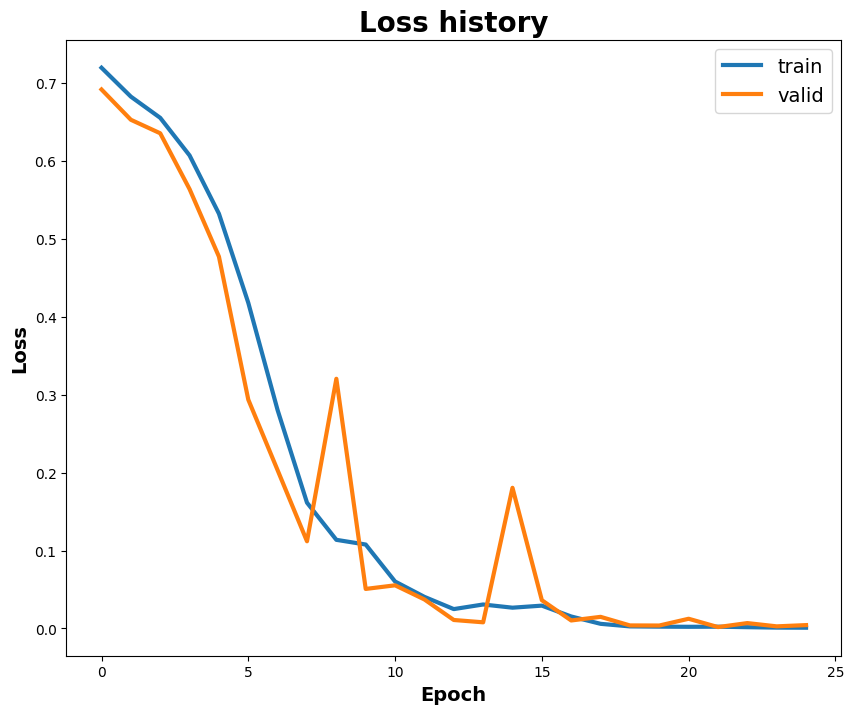

In [9]:
plt.figure(figsize=(10, 8))
plt.plot(train_loss_history, label='train', linewidth=3)
plt.plot(valid_loss_history, label='valid', linewidth=3)
plt.title('Loss history', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=14)

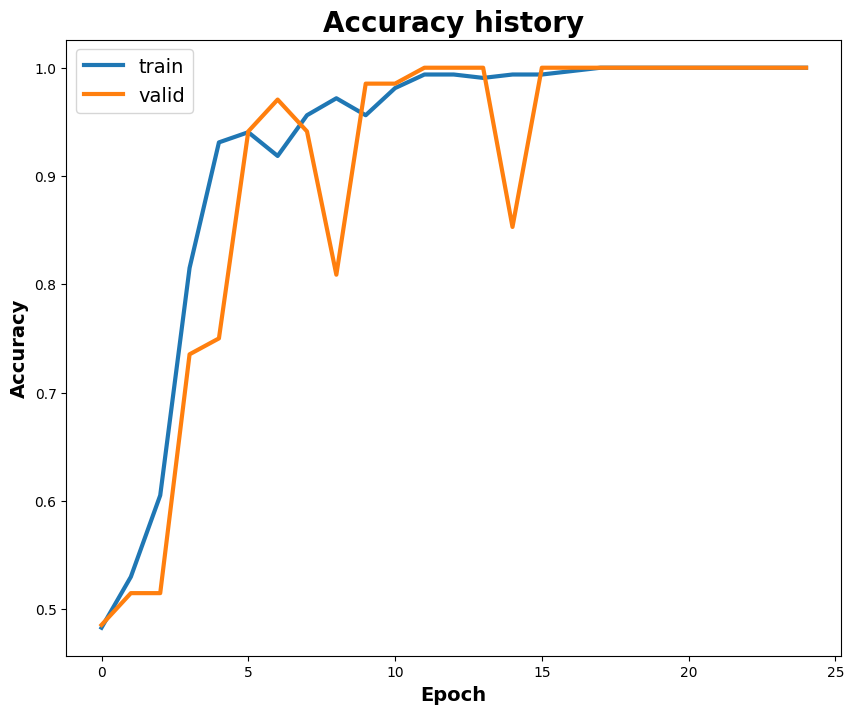

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(train_acc_history, label='train', linewidth=3)
plt.plot(valid_acc_history, label='valid', linewidth=3)
plt.title('Accuracy history', fontsize=20, fontweight='bold')
plt.xlabel('Epoch', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy', fontsize=14, fontweight='bold')
plt.legend(fontsize=14)

In [11]:
def evaluate_model(model, test_loader, criterion, device):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    test_loss = 0.0

    predictions, gt_labels = [], []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
           
            predictions.append(torch.argmax(outputs, dim=1))
            gt_labels.append(labels)

    predictions = torch.cat(predictions).cpu().numpy()
    gt_labels = torch.cat(gt_labels).cpu().numpy()
    
    test_loss /= len(test_loader.dataset)
    
    conf_matrix = confusion_matrix(gt_labels, predictions)
    
    test_accuracy = accuracy_score(gt_labels, predictions)
    test_f1 = f1_score(gt_labels, predictions)
    test_roc_auc = roc_auc_score(gt_labels, predictions)

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test F1 Score: {test_f1:.4f}, Test AUC: {test_roc_auc:.4f}')
    
    return conf_matrix

Test Loss: 0.0051, Test Accuracy: 1.0000, Test F1 Score: 1.0000, Test AUC: 1.0000


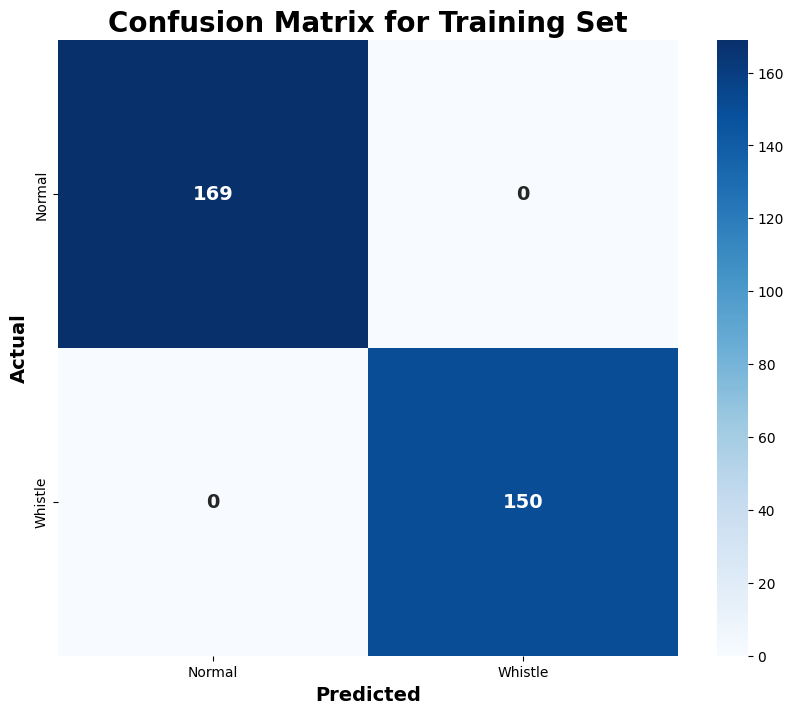

In [12]:
conf_matrix = evaluate_model(model, train_loader, criterion, device)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Whistle'], yticklabels=['Normal', 'Whistle'], annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix for Training Set', fontsize=20, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.show()

Test Loss: 0.0043, Test Accuracy: 1.0000, Test F1 Score: 1.0000, Test AUC: 1.0000


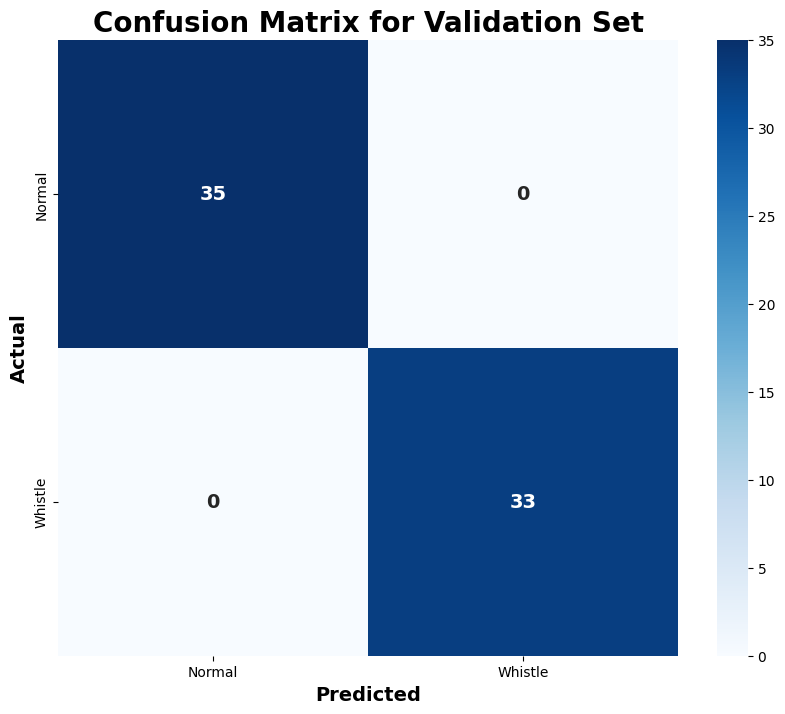

In [13]:
conf_matrix = evaluate_model(model, valid_loader, criterion, device).astype(int)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Whistle'], yticklabels=['Normal', 'Whistle'], annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix for Validation Set', fontsize=20, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.show()

Test Loss: 0.0056, Test Accuracy: 1.0000, Test F1 Score: 1.0000, Test AUC: 1.0000


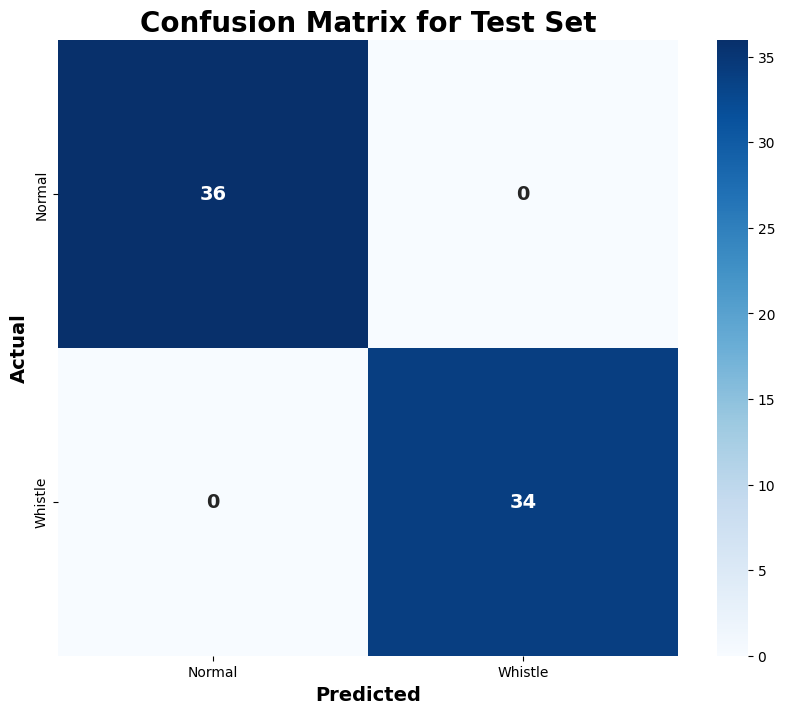

In [14]:
conf_matrix = evaluate_model(model, test_loader, criterion, device).astype(int)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Whistle'], yticklabels=['Normal', 'Whistle'], annot_kws={'size': 14, 'weight': 'bold'})
plt.title('Confusion Matrix for Test Set', fontsize=20, fontweight='bold')
plt.ylabel('Actual', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=14, fontweight='bold')
plt.show()

In [22]:
import os

In [ ]:
model = TransformerModel(n_features=1025, n_classes=2, n_heads=4, n_encoder_layers=4)
model.load_state_dict(torch.load("models/transformer_h4_l4.pth"))
model.to('cpu')

In [28]:
for idx, sound_file in enumerate(os.listdir("sound_data/1000")):
    if idx > 19:
        break

    spec_db = process_audio_data(os.path.join("sound_data/1000", sound_file))
    spec_db = torch.from_numpy(spec_db.T).float()

    model.eval()  # Set the model to evaluation mode
    outputs = model(spec_db.unsqueeze(0))

    print(outputs)

tensor([[ 1.0373, -0.5832]], grad_fn=<AddmmBackward0>)
tensor([[ 4.7289, -4.9413]], grad_fn=<AddmmBackward0>)
tensor([[ 4.9460, -5.2321]], grad_fn=<AddmmBackward0>)
tensor([[ 1.1653, -0.6635]], grad_fn=<AddmmBackward0>)
tensor([[0.4278, 0.1209]], grad_fn=<AddmmBackward0>)
tensor([[ 4.6611, -4.8564]], grad_fn=<AddmmBackward0>)
tensor([[ 4.7407, -4.9219]], grad_fn=<AddmmBackward0>)
tensor([[0.1757, 0.3757]], grad_fn=<AddmmBackward0>)
tensor([[ 1.8101, -1.4002]], grad_fn=<AddmmBackward0>)
tensor([[ 2.9425, -2.7954]], grad_fn=<AddmmBackward0>)
tensor([[ 5.1153, -5.3738]], grad_fn=<AddmmBackward0>)
tensor([[ 4.4642, -4.6279]], grad_fn=<AddmmBackward0>)
tensor([[ 3.9374, -3.9901]], grad_fn=<AddmmBackward0>)
tensor([[ 3.3902, -3.2454]], grad_fn=<AddmmBackward0>)
tensor([[ 1.6462, -1.3230]], grad_fn=<AddmmBackward0>)
tensor([[-1.1028,  1.7414]], grad_fn=<AddmmBackward0>)
tensor([[ 3.4219, -3.4493]], grad_fn=<AddmmBackward0>)
tensor([[ 1.2690, -0.8984]], grad_fn=<AddmmBackward0>)
tensor([[-0.14

In [26]:
for sound_file in os.listdir("sound_data/whistle"):
    spec_db = process_audio_data(os.path.join("sound_data/whistle", sound_file))
    spec_db = torch.from_numpy(spec_db.T).float()

    model.eval()  # Set the model to evaluation mode
    outputs = model(spec_db.unsqueeze(0))

    print(outputs)

tensor([[-3.5980,  4.2264]], grad_fn=<AddmmBackward0>)
tensor([[-2.8875,  3.4020]], grad_fn=<AddmmBackward0>)
tensor([[-2.0583,  2.8377]], grad_fn=<AddmmBackward0>)
tensor([[-3.2619,  4.0928]], grad_fn=<AddmmBackward0>)
tensor([[-3.7682,  4.5166]], grad_fn=<AddmmBackward0>)
tensor([[-3.9482,  4.6624]], grad_fn=<AddmmBackward0>)
tensor([[-1.1324,  1.5764]], grad_fn=<AddmmBackward0>)
